# Model: XGBoost Model

## Initialization

In [1]:
%run init.ipynb

In [152]:
import xgboost as xgb

from sklearn.preprocessing import scale

import great_expectations as ge

RANDOM_STATE = 42

from progressbar import ProgressBar
import seaborn as sns

from data.data import (transform_X_numerical, 
                           transform_X_categorical, 
                           transform_X)

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, cross_val_score, cross_validate


For more information on progressbar. Look here https://pypi.org/project/progressbar2/

## Extract Clean Data

**Separate data into X (features) and y (label) from the raw data**

This is exactly what Ben did in his notebook.

In [255]:
Xy = pd.read_csv('../data/processed/train.csv', index_col='passengerid', dtype={'pclass':str})

**List of Features**

In [330]:
all_columns = ['age', 'fare', 'family_size', 'is_child', 'is_travelling_alone',
       'pclass', 'sex_male', 'embarked_Q', 'embarked_S', 'title_Miss',
       'title_Mr', 'title_Mrs', 'age_bin_10.0_20.0', 'age_bin_20.0_30.0',
       'age_bin_30.0_40.0', 'age_bin_40.0_50.0', 'age_bin_50.0_60.0',
       'age_bin_60.0_inf']

important_features = ['title_Mr', 'title_Mrs', 'family_size', 'is_child', 'pclass']
important_features = ['title_Mr', 'pclass_2', 'pclass_3', 'family_size', 'fare', 'age']
#important_features = ['title_Mr',  'pclass_1', 'pclass_2', 'family_size',]

#important_features = all_columns

In [331]:
X_all = transform_X(Xy.drop(['name'], axis=1), 
                    numerical_columns=["age", "fare", "family_size"],
    categorical_columns=[
        "sex",
        "embarked",
        "title",
        "age_bin",
        "is_child",
        "is_travelling_alone",
        "pclass",
    ], )
X_all.columns = X_all.columns.str.replace(', ','_').str.replace(r'\[|\]|\(|\)','', regex=True)
X_all

X = X_all[important_features]
X.describe()

y = Xy['survived']
X.shape

X.columns

,age,fare,family_size,is_child,is_travelling_alone,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,...,age_bin_0.0_10.0,age_bin_10.0_20.0,age_bin_20.0_30.0,age_bin_30.0_40.0,age_bin_40.0_50.0,age_bin_50.0_60.0,age_bin_60.0_inf,pclass_1,pclass_2,pclass_3
passengerid,,,,,,,,,,,,,,,,,,,,,
1,-0.590381,-0.502445,0.059160,False,False,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.614749,0.786845,0.059160,False,False,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
3,-0.289098,-0.488854,-0.560975,False,True,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0.388787,0.420730,0.059160,False,False,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
5,0.388787,-0.486337,-0.560975,False,True,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,-0.213778,-0.386671,-0.560975,False,True,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
888,-0.816343,-0.044381,-0.560975,False,True,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
889,-0.590381,-0.176263,1.299429,False,False,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


,title_Mr,pclass_2,pclass_3,family_size,fare,age
count,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02,8.910000e+02
mean,0.602694,0.206510,0.551066,-2.392400e-17,3.987333e-18,3.987333e-17
std,0.489615,0.405028,0.497665,1.000562e+00,1.000562e+00,1.000562e+00
min,0.000000,0.000000,0.000000,-5.609748e-01,-6.484217e-01,-2.215800e+00
25%,0.000000,0.000000,0.000000,-5.609748e-01,-4.891482e-01,-5.903809e-01
50%,1.000000,0.000000,1.000000,-5.609748e-01,-3.573909e-01,1.218402e-02
75%,1.000000,0.000000,1.000000,5.915988e-02,-2.424635e-02,4.565756e-01
max,1.000000,1.000000,1.000000,5.640372e+00,9.667167e+00,3.778215e+00


(891, 6)

Index(['title_Mr', 'pclass_2', 'pclass_3', 'family_size', 'fare', 'age'], dtype='object')

## Train Test Split Data

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

X_train.describe()
X_test.describe()

xg_cl = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=1000, 
                          seed=123,
                          colsample_bytree=0.3, 
                          learning_rate=0.01, 
                          max_depth=3, 
                          max_features='sqrt',
                          random_state=RANDOM_STATE,
                          subsample=0.2)

xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)

,title_Mr,pclass_2,pclass_3,family_size,fare,age
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.609551,0.212079,0.558989,0.017353,0.007693,-0.007763
std,0.488194,0.409068,0.496857,1.043392,1.046390,0.996493
min,0.000000,0.000000,0.000000,-0.560975,-0.648422,-2.215800
25%,0.000000,0.000000,0.000000,-0.560975,-0.488854,-0.590381
50%,1.000000,0.000000,1.000000,-0.560975,-0.357391,0.012184
75%,1.000000,0.000000,1.000000,0.059160,-0.034314,0.456576
max,1.000000,1.000000,1.000000,5.640372,9.667167,3.778215


,title_Mr,pclass_2,pclass_3,family_size,fare,age
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,0.575419,0.184358,0.519553,-0.069024,-0.030599,0.030880
std,0.495666,0.388863,0.501019,0.806888,0.794268,1.018825
min,0.000000,0.000000,0.000000,-0.560975,-0.648422,-2.184918
25%,0.000000,0.000000,0.000000,-0.560975,-0.489442,-0.628041
50%,1.000000,0.000000,1.000000,-0.560975,-0.356469,0.049844
75%,1.000000,0.000000,1.000000,0.059160,0.004152,0.464108
max,1.000000,1.000000,1.000000,3.159833,4.634417,3.100329


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.2, verbosity=1)

In [333]:
ii_y_pred, ii_predicted_accuracy_score, ii_cv_scores = pm.calc_model_rst_table_metrics(xg_cl, X_train, y_train, X_test, y_test, 
                                                      model_name='xgb_1', cv=5, verbose=True)
    


Accuracy Score on X_test,y_test:  0.8212


Cross Validation Scores:
	Accuracy 	: 0.8300 (+/- 0.0558)
	Recall		: 0.7012 (+/- 0.0954)
	Precision	: 0.8213 (+/- 0.0856)
	F1		: 0.7560 (+/- 0.0848)


11/06/19, xgb_1,  <kaggle_accuracy>, 0.8300, 0.7012,0.8213,0.7560


# Tuning the Model (Best LogReg Model Accuracy = 0.8384)

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [334]:
gbm_param_grid = {'learning_rate': [0.01],
                  'n_estimators': [1000],
                  'subsample': [0.2, 0.3], 
                  'max_depth': [3],
                  'max_features': ['sqrt'],
                  'random_state': [RANDOM_STATE], 
                  'colsample_bytree':[0.3, 0.4, 0.5]}

gsearch = GridSearchCV(estimator=xg_cl,
                       param_grid=gbm_param_grid,
                       scoring='accuracy', cv=4, verbose=1, n_jobs=4)


gsearch.fit(X, y)

print("\n\nBest parameters found: ",gsearch.best_params_)
print("Highest Accuracy: ", gsearch.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    2.0s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.3, gamma=0,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=3, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=1000, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_s...,
                                     scale_pos_weight=1, seed=123, silent=None,
                                     subsample=0.2, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5],
                         'learning_rate': [0.01], 'max_depth': [3],
       



Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.3}
Highest Accuracy:  0.8338945005611672


In [308]:
with pd.option_context('display.max_rows', 20):
	pd.DataFrame(gsearch.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.187667,0.18977,0.222233,0.225732,0.28691,0.295669
std_fit_time,0.00219089,0.00182197,0.0288588,0.0295795,0.0120328,0.0134189
mean_score_time,0.00518358,0.0046913,0.00610727,0.00564182,0.00756025,0.00788045
std_score_time,0.000537452,0.000331546,0.000168761,0.000397683,0.000736854,0.000937203
param_colsample_bytree,0.3,0.3,0.4,0.4,0.5,0.5
param_learning_rate,0.01,0.01,0.01,0.01,0.01,0.01
param_max_depth,3,3,3,3,3,3
param_max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt
param_n_estimators,1000,1000,1000,1000,1000,1000
param_random_state,42,42,42,42,42,42


# Selecting Important Features

In [336]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=20):
    
    predictors = X.columns.tolist()
    print(predictors)
    
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    if performCV:
        print(f"CV Score : Mean - {np.mean(cv_score)} | Std - {np.std(cv_score)} | Min - {np.min(cv_score)} | Max - {np.max(cv_score)}")
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

modelfit(xg_cl, X, y)

# Simplify Model

In [311]:
from yellowbrick.features import Rank1D

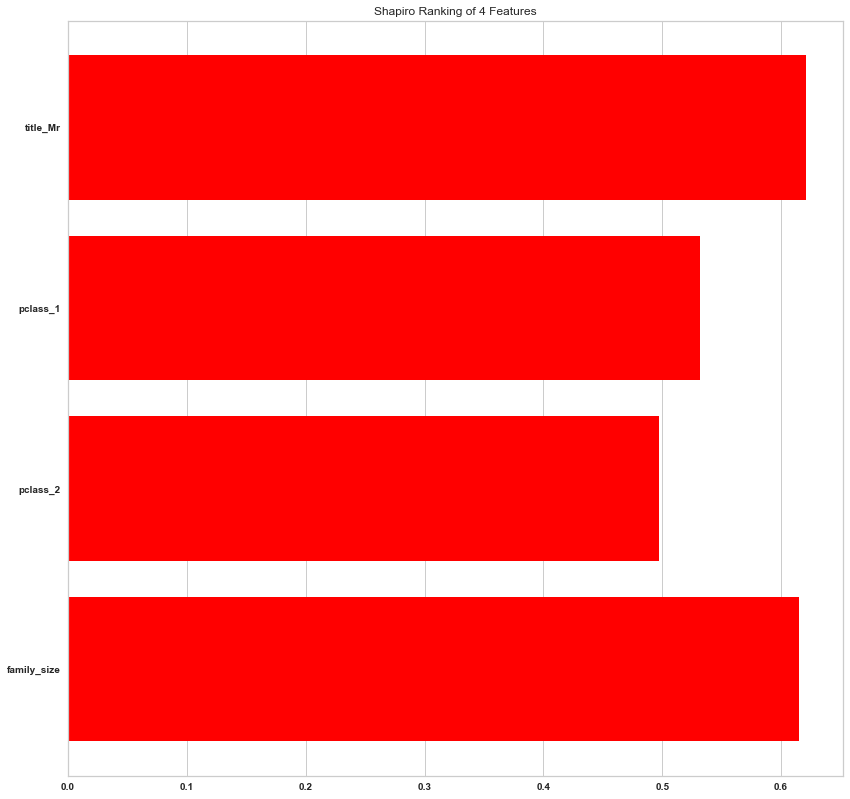

In [312]:
# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro', size=(1000,1000))

visualizer.fit(X, y, )           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show();          # Finalize and render the figure

https://www.districtdatalabs.com/visualize-data-science-pipeline-with-yellowbrick

In [344]:
from cycler import cycler
import matplotlib as mpl
from yellowbrick.model_selection import FeatureImportances

In [345]:
model = xg_cl

FeatureImportances(absolute=True,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1119d43c8>,
                   colormap=None, colors=None, is_fitted='auto',
                   labels=Index(['title_Mr', 'pclass_1', 'pclass_2', 'family_size'], dtype='object'),
                   model=None, relative=False, stack=False, xlabel=None)

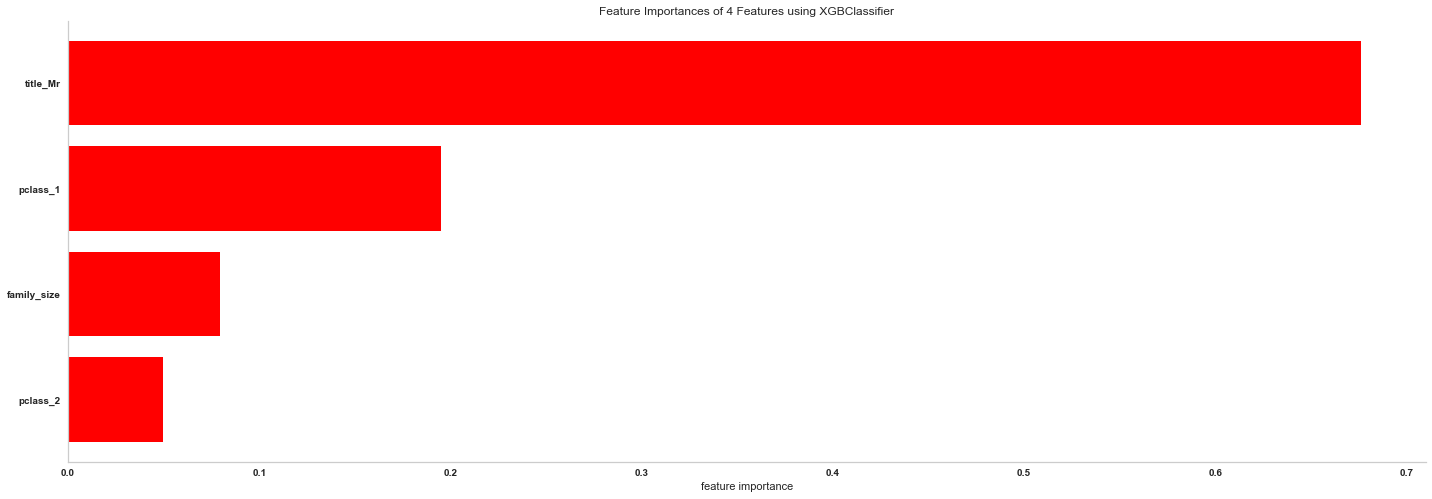

In [315]:
# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red'])
fig = plt.gcf()
fig.set_size_inches(20,20)
ax = plt.subplot(311)
labels = X.columns

viz = FeatureImportances(model, ax=ax, labels=labels, relative=False, absolute=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof()

# Prepare Submission

In [339]:
X_holdout = pd.read_csv('../data/processed/holdout.csv', index_col='passengerid', dtype={'pclass':str})
X_test_kaggle_public = transform_X(X_holdout).reindex(X_test.columns, axis=1)
X_test_kaggle_public.columns

X_test_kaggle_public.describe()

Index(['title_Mr', 'pclass_2', 'pclass_3', 'family_size', 'fare', 'age'], dtype='object')

,title_Mr,pclass_2,pclass_3,family_size,fare,age
count,418.000000,418.000000,418.000000,4.180000e+02,4.180000e+02,4.180000e+02
mean,0.586124,0.222488,0.521531,-2.974760e-17,5.524555e-17,5.949521e-17
std,0.493117,0.416416,0.500135,1.001198e+00,1.001198e+00,1.001198e+00
min,0.000000,0.000000,0.000000,-5.534426e-01,-6.374127e-01,-2.310618e+00
25%,0.000000,0.000000,0.000000,-5.534426e-01,-4.958854e-01,-6.348362e-01
50%,1.000000,0.000000,1.000000,-5.534426e-01,-3.783302e-01,-2.071555e-02
75%,1.000000,0.000000,1.000000,1.056429e-01,-7.329887e-02,4.379558e-01
max,1.000000,1.000000,1.000000,6.037412e+00,8.545771e+00,3.510478e+00


In [341]:
X_test_kaggle_public

,title_Mr,pclass_2,pclass_3,family_size,fare,age
passengerid,,,,,,
892,1,0,1,-0.553443,-0.497079,0.324727
893,0,0,1,0.105643,-0.511942,1.284291
894,1,1,0,-0.553443,-0.463770,2.435767
895,1,0,1,-0.553443,-0.482143,-0.251011
896,0,0,1,0.764728,-0.417167,-0.634836
...,...,...,...,...,...,...
1305,1,0,1,-0.553443,-0.493121,0.209580
1306,0,0,0,-0.553443,1.314552,0.670170
1307,1,0,1,-0.553443,-0.507461,0.631788


In [350]:
y_pred = (pd.Series(xg_cl.predict(X_test_kaggle_public), 
                   index=X_test_kaggle_public.index, name='Survived').to_frame().sort_index()
         )

xg_cl
X_test_kaggle_public.columns

y_pred.index.names = ['PassengerId']
y_pred

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.2, verbosity=1)

Index(['title_Mr', 'pclass_2', 'pclass_3', 'family_size', 'fare', 'age'], dtype='object')

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [347]:
y_submission = (pd.read_csv('../data/raw/gender_submission.csv')
                .set_index('PassengerId')
               )
y_submission

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [349]:
filename = 'xgb_model_2.csv'
y_pred.to_csv(filename)

y_pred_file = (pd.read_csv(filename)
                .set_index('PassengerId')
               )

assert (y_pred_file.index == y_submission.index).all()
assert y_pred_file.index.names == y_submission.index.names
assert (y_pred_file.columns == y_submission.columns).all()

assert (y_pred.index == y_submission.index).all()
assert y_pred.index.names == y_submission.index.names
assert (y_pred.columns == y_submission.columns).all()